# Прогнозирование цитируемости научной публикации

In [1]:
# Настройка пути к файлу с данными
data_fp = 'data/predict.csv'

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer


plt.style.use('ggplot')
%matplotlib inline

In [3]:
df = pd.read_csv(data_fp)

# Оглавление

* [Исследование-данных](#EDA---Исследование-данных)
    * [Предположительные характеристики статьи](#Предположительные-характеристики-статьи)
    * [Пропуски в данных](#Пропуски-в-данных)
    * [Статистические характеристики признаков](#Статистические-характеристики-признаков)
    * [Корреляции и распределения](#Корреляции-и-распределения)
* [Предобработка данных](#Предобработка-данных)
    * [Выбросы](#Выбросы)
* [Feature Engineering](#Feature-Engineering)
    * [Влияние по двум переменным](#Влияние-по-двум-переменным)
* [Разработка моделей](#Разработка-моделей)
    * [Линейная регрессия](#Линейная-регрессия)
    * [KN регрессор](#KN-регрессор)
    * [Случайный лес](#Случайный-лес)
    * [Дерево решений](#Дерево-решений)
* [Результаты](#Результаты)

# EDA - Исследование данных

## Предположительные характеристики статьи

In [4]:
df.columns.to_list()

['recency',
 'topic_rank',
 'diversity',
 'authors_mean_rank',
 'authors_mean_hindex',
 'authors_mean_gindex',
 'authors_mean_sociality',
 'authors_mean_pagerank',
 'authors_mean_productivity',
 'journal_pagerank',
 'journal_rank',
 'title_len',
 'abstract_len',
 'n_authors',
 'c5',
 'log_authors_mean_sociality']

* **recency** - оценка рецензии (или количество рецензий)
* **topic_rank** - рейтинг темы статьи
* **diversity** - полнота раскрытия темы (возможно степень плагиата)
* **authors_mean_rank** - средний рейтинг авторов статьи
* **authors_mean_hindex** - средний индекс Хирша авторов статьи
* **authors_mean_gindex** - средний g-индекс авторов статьи
* **authors_mean_sociality** - средняя "общительность" авторов статьи (возможно, степень склонности автора к коллаборации)
* **journal_rank** - рейтинг журнала
* **title_len** - длина заголовка статьи
* **abstract_len** - длина статьи
* **n_authors** - количество авторов
* **c5** - цитируемость статьи через пять лет - целевая характеристика
* **log_authors_mean_sociality** - логарифм от "authors_mean_sociality"

## Пропуски в данных

In [5]:
na_sum = df.isna().sum()[df.isna().sum() != 0]
pd.DataFrame(
    {'count': na_sum.to_numpy(), 
     'percentage': np.round((na_sum.to_numpy() / df.shape[0] * 100), 1)
    }, 
    index=na_sum.index
)

,count,percentage
authors_mean_rank,6,1.3
authors_mean_hindex,6,1.3
authors_mean_gindex,6,1.3
authors_mean_sociality,6,1.3
authors_mean_pagerank,479,100.0
authors_mean_productivity,479,100.0
journal_pagerank,479,100.0
journal_rank,39,8.1
log_authors_mean_sociality,6,1.3


Видно, что колонки *authors_mean_pagerank*, *authors_mean_productivity* и *journal_pagerank* - совсем пустые. От них нужно будет избавиться.

Колонки *authors_mean_rank*, *authors_mean_hindex*, *authors_mean_gindex*, *authors_mean_sociality*, *journal_rank* и *log_authors_mean_sociality* имеют мало пропусков, их можно попробовать заполнить.

Можно заметить также, что колонки *authors_mean_rank*, *authors_mean_hindex*, *authors_mean_gindex*, и *authors_mean_sociality* имеют одинаковое количество пропусков. Проверим, вдруг эти пропуски принадлежат одним и тем же строкам данных:

In [6]:
suspicious_columns = ['authors_mean_rank', 'authors_mean_hindex', 'authors_mean_gindex', 
                      'authors_mean_sociality', 'log_authors_mean_sociality']
df[df['authors_mean_rank'].isna()].loc[:, suspicious_columns]

,authors_mean_rank,authors_mean_hindex,authors_mean_gindex,authors_mean_sociality,log_authors_mean_sociality
418,NaN,NaN,NaN,NaN,NaN
422,NaN,NaN,NaN,NaN,NaN
423,NaN,NaN,NaN,NaN,NaN
451,NaN,NaN,NaN,NaN,NaN
458,NaN,NaN,NaN,NaN,NaN
464,NaN,NaN,NaN,NaN,NaN


Действительно, эти строки можно удалить. В них отсутствует целая четверть информации и их довольно мало.

Остается только придумать, что делать с колонкой journal_rank, ведь в ней целых 8.2% данных пропущено. Это мало, чтобы удалить колонку целиком, а переменная может быть довольно важна. Также, датасет не очень большой для того чтобы можно было бы довольствоваться лишь заполнением данных на основе выборочного среднего или медианы, поэтому будем вставлять пропуски методом ближайших соседей

In [7]:
# Удаляем колонки сразу, т.к. при визуализации они будут мешать
# Также, удалим пока что колонку "log_authors_mean_sociality", логарифм мы всегда взять успеем
columns_to_drop = ['authors_mean_pagerank', 'authors_mean_productivity', 'journal_pagerank', 'log_authors_mean_sociality']
df.drop(columns_to_drop, axis=1, inplace=True, errors='ignore')
# удаляем малоинформативные строки:
df.drop(df[df['authors_mean_rank'].isna()].index, axis=0, inplace=True, errors='ignore')

In [8]:
# заполняем пропущенные данные методом ближайших соседей
knn_imp = KNNImputer(n_neighbors=5)
df = pd.DataFrame(knn_imp.fit_transform(df), index=df.index, columns=df.columns)

## Статистические характеристики признаков

In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
recency,473.0,13.382664,5.847232,5.000000,8.000000,13.00000,18.000000,25.000000
topic_rank,473.0,10.088795,5.756402,1.000000,5.000000,10.00000,15.000000,20.000000
diversity,473.0,-0.668007,0.601742,-2.995732,-1.083763,-0.51693,-0.150066,-0.056685
authors_mean_rank,473.0,741.769615,581.948922,1.000000,265.000000,596.00000,1141.000000,2336.000000
authors_mean_hindex,473.0,0.844051,0.363961,0.000000,1.000000,1.00000,1.000000,1.125000
authors_mean_gindex,473.0,0.844668,0.364351,0.000000,1.000000,1.00000,1.000000,1.166667
authors_mean_sociality,473.0,3.411132,2.790555,0.000000,1.000000,3.00000,5.000000,15.000000
journal_rank,473.0,146.397040,110.380939,1.000000,55.000000,122.00000,219.000000,436.000000
title_len,473.0,95.469345,38.368524,16.000000,68.000000,92.00000,117.000000,279.000000
abstract_len,473.0,1175.177590,651.065182,0.000000,779.000000,1206.00000,1597.000000,3655.000000


## Корреляции и распределения

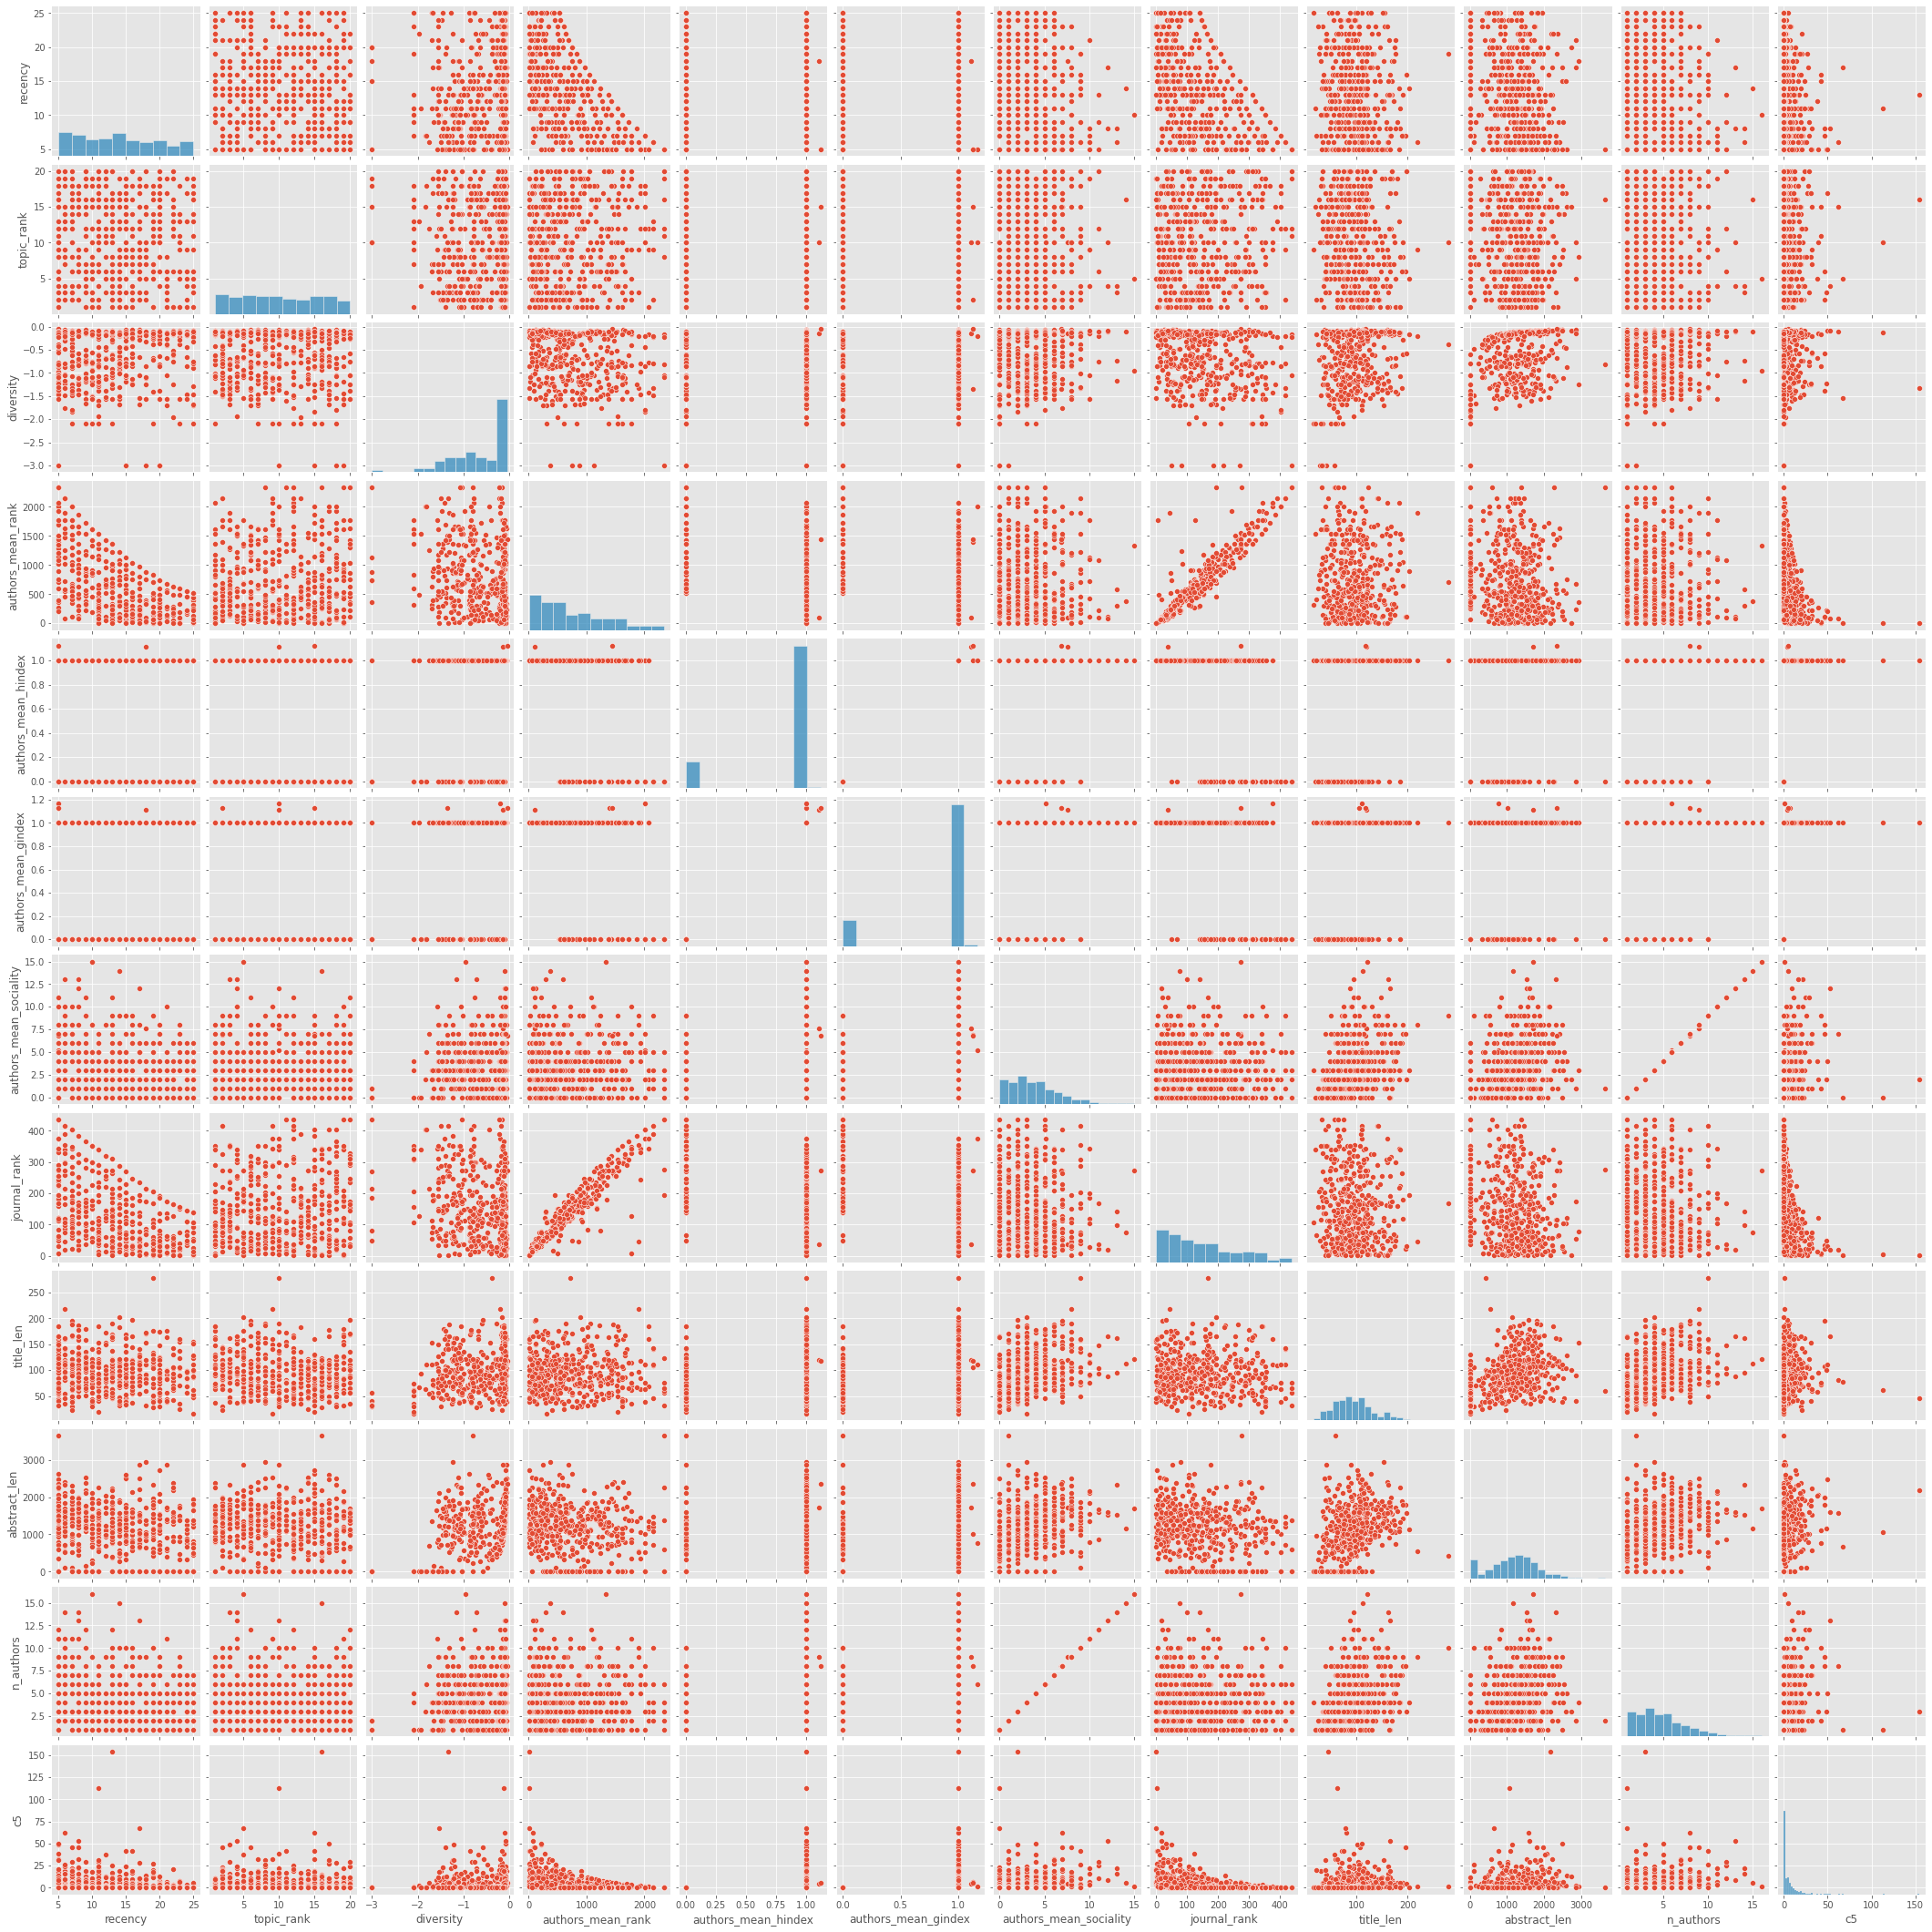

In [10]:
sns.pairplot(df);

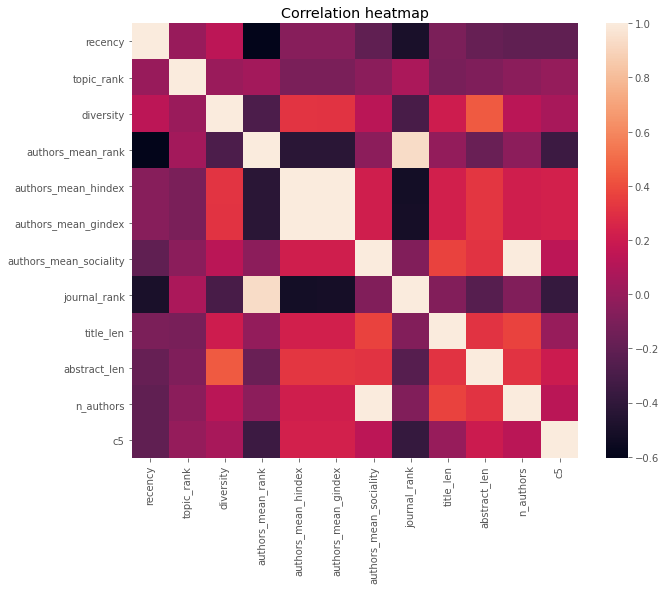

In [11]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Correlation heatmap')
sns.heatmap(df.corr());

Заметим, что некоторые характеристики имеют очень высокую степень коллинеарности.

* *authors_mean_hindex* и *authors_mean_gindex* - дают примерно одну и ту же информацию - показатель научной продуктивности
* *аuthors_sociality* и *n_authors* - тоже говорят примерно об одном и тоже
* *journal_rank* и *аuthors_mean_rank* - вот здесь информацией лучше не пренебрегать, ведь авторы высокого ранга могут публиковаться и в журналах низкого. Также может быть наоборот. Ведь возможность публикации зависит не от автора, а от статьи.

Высокую коллинеарность имеют колонки *divercity* и *abstract_len*. Это логично, ведь чем подробнее раскрыта тема, тем больше длина текста. Но эти характеристики не говорят об одном и том же. Если показатель *divercity (полнота раскрытия темы)* высок, а *abstract_len (размер статьи)* низок, то это может положительно влиять на одобрение читателей - тема раскрыта емко. А если показатель *abstract_len* высок, а *divercity* - низок, значит в статье одна вода и цитировать ее будут вряд-ли.

*divercity* и *authors_mean_gindex* (*authors_mean_hindex*) тоже взаимосвязаны. "Научно-продуктивный" автор скорее всего раскроет тему подробно. Но как у "продуктивного" автороа может быть плохое настроение на написание статьи, так и у "непродуктивного" может грянуть озарение.

Некоторые диаграммы рассеяния могут показаться довольно интересными. Например между *recensy* и *jouranl_rank* можно увидеть, что точки как бы ограничены сверху прямой линией. Если полагать, что *recensy* говорит о количестве рецензий, а не об оценке, данной в рецензии, то это имеет долю смысла: чем выше ранг журнала или автора, тем более сложные темы он освещает. Сложную тему способны комментировать лишь профессионалы, а простую могут комментировать многие. Поэтому можно ожидать, что низкоранговый журнал будут рецензировать больше людей, чем высокоранговый, но нельзя ожидать, что высокоранговый журнал будут рецензировать профаны.


# Предобработка данных

## Выбросы

### Целевая переменная (c5)

Если взглянуть на ящик с усами, поймем, что есть два случая, когда цитирование статьи слишком велико.

<AxesSubplot:>

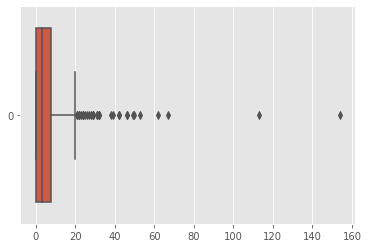

In [12]:
sns.boxplot(data=df['c5'], orient='hor')

Ограничим значения переменной до 60, приравняв к нему экстремальные значения

In [13]:
df.loc[df[df['c5']>60].index, 'c5'] = 60

### recency

<AxesSubplot:>

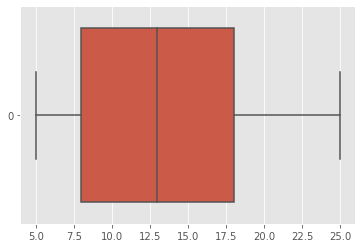

In [14]:
sns.boxplot(data=df['recency'], orient='hor')

### topic_rank

<AxesSubplot:>

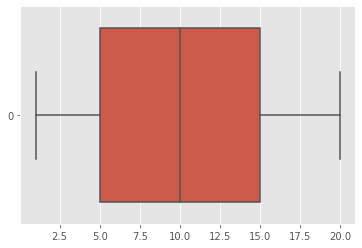

In [15]:
sns.boxplot(data=df['topic_rank'], orient='hor')

### diversity

<AxesSubplot:>

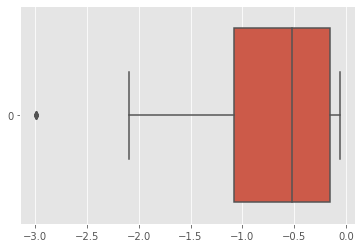

In [16]:
sns.boxplot(data=df['diversity'], orient='hor')

In [17]:
df.loc[df[df['diversity'] < -2.1].index, 'diversity'] = -2.1

### authors_mean_rank

<AxesSubplot:>

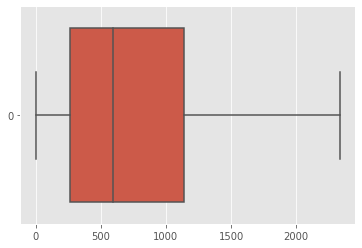

In [18]:
sns.boxplot(data=df['authors_mean_rank'], orient='hor')

### authors_mean_hindex

In [19]:
df['authors_mean_hindex'].value_counts()

1.000000    397
0.000000     74
1.125000      1
1.111111      1
Name: authors_mean_hindex, dtype: int64

Здесь мы видим, что переменных со значением 1.х мало. Ограничим колонку единицей.

In [20]:
df.loc[df[df['authors_mean_hindex'] > 1].index, 'authors_mean_hindex'] = 1

### authors_mean_sociality

<AxesSubplot:>

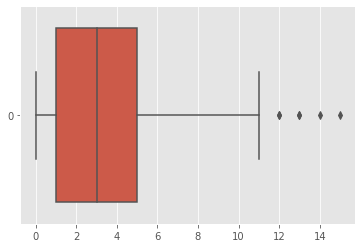

In [21]:
sns.boxplot(data=df['authors_mean_sociality'], orient='hor')

In [22]:
df.loc[df[df['authors_mean_sociality'] > 11].index, 'authors_mean_sociality'] = 11

### journal_rank

<AxesSubplot:>

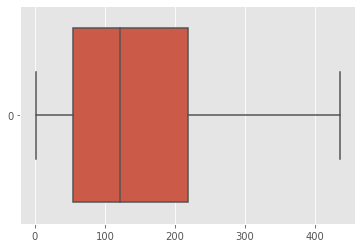

In [23]:
sns.boxplot(data=df['journal_rank'], orient='hor')

### title_len

<AxesSubplot:>

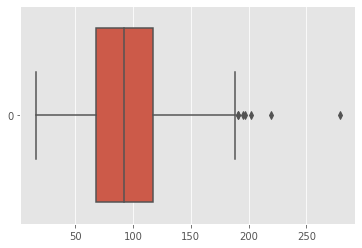

In [24]:
sns.boxplot(data=df['title_len'], orient='hor')

In [25]:
df.loc[df[df['title_len'] > 190].index, 'title_len'] = 190

### abstract_len

<AxesSubplot:>

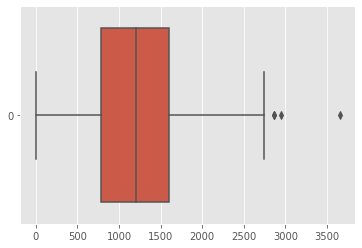

In [26]:
sns.boxplot(data=df['abstract_len'], orient='hor')

In [27]:
df.loc[df[df['abstract_len'] > 2700].index, 'abstract_len'] = 2700

В колонке есть нулевые значения. Если подразумевать, что колонка является абстрактной длиной публикации, то такого быть не может. Заменим нули на медиану по колонке

In [28]:
df.loc[df[df['abstract_len'] == 0].index, 'abstract_len'] = df['abstract_len'].median()

### n_authors

<AxesSubplot:>

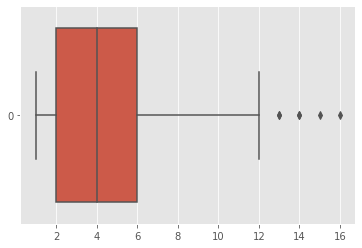

In [29]:
sns.boxplot(data=df['n_authors'], orient='hor')

In [30]:
df.loc[df[df['n_authors'] > 12].index, 'n_authors'] = 12

# Feature Engineering

## Влияние по двум переменным

Давайте разобьем статьи на категории и отметим, какие статьи не цитируются совсем, какие цитируются 1 раз, 2-4 раза и т.д.

Мы увидим следующую картину: *recency*, *authors_mean_rank* и *journal_rank* образуют взаимосвязи. Статьи, с одинаковым количеством цитирования имеют склонность лежать на одной прямой.

In [31]:
test_df = df.copy()
test_df['c5_class'] = pd.cut(x=test_df['c5'], 
                             bins=[-1, 0, 1, 4, 10, 300], 
                             labels=['zero', 'one', 'one_four', 'four_ten', 'others'])

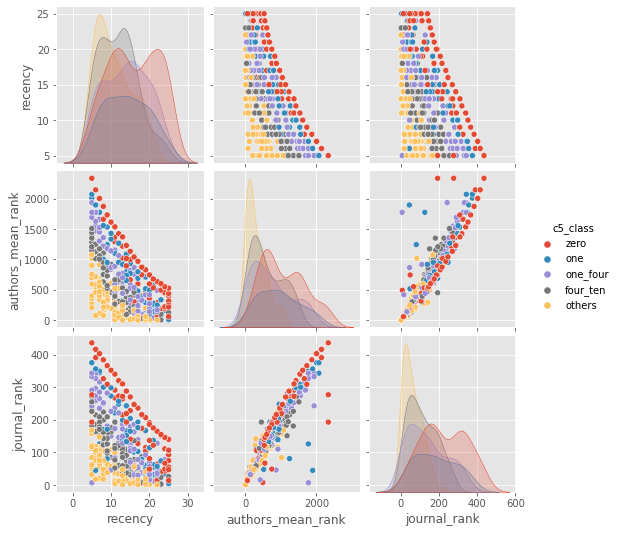

In [32]:
sns.pairplot(test_df.loc[:, ['recency', 'authors_mean_rank', 'journal_rank', 'c5_class']], hue='c5_class')

In [33]:
lr = LinearRegression()
X = test_df[test_df['c5_class']=='zero']['recency'].to_numpy().reshape(-1, 1)
y = test_df[test_df['c5_class']=='zero']['journal_rank'].to_numpy().reshape(-1, 1)
lr.fit(X, y)

LinearRegression()

In [34]:
lr.coef_[0, 0]

-16.404899291014242

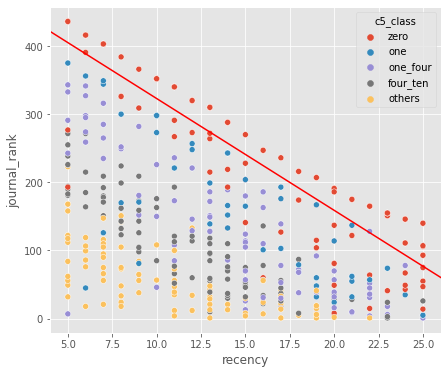

In [35]:
fig, ax = plt.subplots(figsize=(7, 6))
sns.scatterplot(data=test_df, x='recency', y='journal_rank', hue=test_df['c5_class'], ax=ax)
x_0, x_1 = 5, 25
y_0, y_1 = lr.predict([[x_0]])[0, 0], lr.predict([[x_1]])[0, 0]
ax.axline((5, y_0), (25, y_1), color='red')
k, b = lr.coef_[0], lr.intercept_[0]

Выполним преобразование по формулам:

$$x' = x * cos(\alpha) - y * sin(\alpha) $$
$$y' = x * sin(\alpha) + y * cos(\alpha)$$

<AxesSubplot:xlabel='recency_rot', ylabel='journal_rank_rot'>

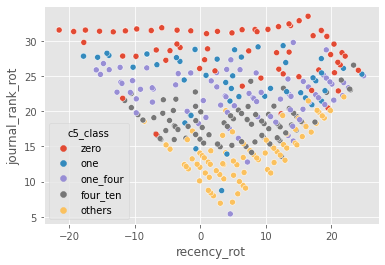

In [36]:
test_df['recency_rot'] = test_df['recency'] * np.sin(-np.arctan(k)) - test_df['journal_rank'] * np.cos(-np.arctan(k))
test_df['journal_rank_rot'] = test_df['recency'] * np.sin(-np.arctan(k)) + test_df['journal_rank'] * np.cos(-np.arctan(k))
sns.scatterplot(data=test_df, x='recency_rot', y=test_df['journal_rank_rot'], hue='c5_class')

*journal_rank_rot* нам очень полезен, так как несет ценную информацию о цитируемости

In [37]:
df['feature_1'] = test_df['journal_rank_rot']

# Разработка моделей

In [38]:
X = df.drop('c5', axis=1)
X = pd.DataFrame(Normalizer().fit_transform(X), columns=X.columns)
y = df['c5']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Линейная регрессия

In [39]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f'r^2: {r2_score(y_test, y_pred)}')
print(f'mse: {mean_squared_error(y_pred, y_test)}')

r^2: 0.5225990317267858
mse: 63.63413400704671


## KN регрессор

In [40]:
knr = KNeighborsRegressor()
gcv = GridSearchCV(estimator=knr,
                   param_grid={
                       'n_neighbors': [1, 3, 5, 7, 11, 15, 21, 31],
                       'p': [1, 2, 3, 4]
                   },
                   scoring=None)
gcv.fit(X, y)
print('параметры:', gcv.best_params_)
print('score:', gcv.best_score_)
y_pred = gcv.best_estimator_.predict(X_test)
print(f'r^2: {r2_score(y_test, y_pred)}')
print(f'mse: {mean_squared_error(y_pred, y_test)}')

параметры: {'n_neighbors': 11, 'p': 1}
score: 0.21630836866136524
r^2: 0.4477851286955973
mse: 73.6062921036183


## Случайный лес

In [41]:
rfr = RandomForestRegressor()
gcv = GridSearchCV(estimator=rfr,
                   param_grid={
                       'n_estimators': np.arange(10, 160, 50),
                       'max_depth': [10],
                       'min_samples_split': np.arange(2, 20, 4),
                       'random_state': [42]
                   },
                   scoring=None)
gcv.fit(X, y)
print('параметры:', gcv.best_params_)
print('score:', gcv.best_score_)
y_pred = gcv.best_estimator_.predict(X_test)
print(f'r^2: {r2_score(y_test, y_pred)}')
print(f'mse: {mean_squared_error(y_pred, y_test)}')

параметры: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 110, 'random_state': 42}
score: 0.5389667630427334
r^2: 0.9494570333952063
mse: 6.737015891853994


## Дерево решений

In [42]:
dtr = DecisionTreeRegressor()
gcv = GridSearchCV(estimator=dtr,
                   param_grid={
                       'max_depth': np.arange(1, 20),
                       'min_samples_split': np.arange(2, 20, 1),
                       'random_state': [42]
                   },
                   scoring=None)
gcv.fit(X, y)
print('параметры:', gcv.best_params_)
print('score:', gcv.best_score_)
y_pred = gcv.best_estimator_.predict(X_test)
print(f'r^2: {r2_score(y_test, y_pred)}')
print(f'mse: {mean_squared_error(y_pred, y_test)}')

параметры: {'max_depth': 14, 'min_samples_split': 5, 'random_state': 42}
score: 0.34762667705409517
r^2: 0.9845531749358636
mse: 2.0589512829645806


# Результаты

Лучшим алгоритмом для данной задачи оказалось "Регрессионное дерево решений" с параметрами:

* **max_depth**: 14
* **min_samples_split**: 5

Его оценки:
* **r^2**: 0.98
* **mse**: 2.06


* Автор тетрадки: Здоров Филипп Кириллович

* Тестовое задание на стажировку JetBrains